Comparison of criteria for correlating hits
===========================================

This notebook shows how to use the KM3Net package to compare two different criteria for correlating L0 hits. 

The quadratic difference criterion checks whether the distance between two hits in space is large than the distance in time times the speed of light. The Match 3B criterion is a more restrictive criterion that also considers a maximum distance between two hits, based on a parameter called `roadwidth` which is the assumed maximim distance a photon can travel through seawater.

As usual we start with a number of imports and reading a sample input file.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pyplot
from km3net.kernels import QuadraticDifferenceSparse, PurgingSparse
import km3net.util as util
window_width = 1500
N,x,y,z,ct = util.get_real_input_data("sample.txt")
print ("Read", N, "hits from file")

Read 5000 hits from file


We also initialize the GPU, and instantiate the Python interfaces to the GPU codes to get the GPU kernels compiled.

In [2]:
context, cc = util.init_pycuda()
qd_kernel = QuadraticDifferenceSparse(N, cc=cc)
purging = PurgingSparse(N, cc)

The next step is to compute the correlation tables for both criteria using the sample input we read in earlier. The Quadratic Difference criterion is computed by the [QuadraticDifferenceSparse](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/kernels.html#km3net-kernels-quadraticdifferencesparse) object on the GPU, for the 3B criterion we use the [correlations_cpu_3B](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/utils.html#km3net.util.correlations_cpu_3B) function CPU implemented in Python.

In [3]:
#obtain sparse matrix for Quadratic Difference and convert to dense
d_col_idx, d_prefix_sums, d_degrees, total_hits = qd_kernel.compute(x, y, z, ct)
matrix_qd = util.sparse_to_dense(d_prefix_sums, d_col_idx, N, total_hits)

#obtain correlation matrix for Match 3B criterion
correlations_3b = np.zeros((window_width,N), dtype=np.uint8)
correlations_3b = util.correlations_cpu_3B(correlations_3b, x, y, z, ct)
matrix_3b = util.get_full_matrix(correlations_3b)

Let's start our comparison by looking at the two correlation matrices we've just produced.

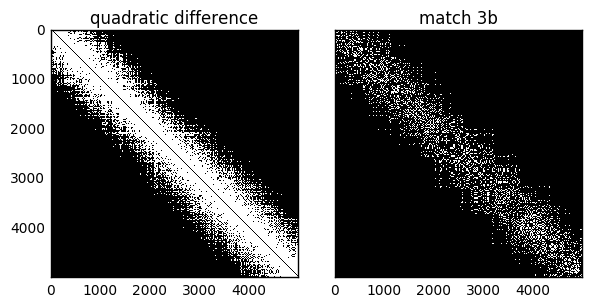

In [4]:
f, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
f.tight_layout()
ax1.set_title('quadratic difference')
ax2.set_title('match 3b')
ax1.set_adjustable('box-forced')
ax2.set_adjustable('box-forced')
ax1.imshow(matrix_qd, cmap=pyplot.cm.bone, interpolation='nearest')
ax2.imshow(matrix_3b, cmap=pyplot.cm.bone, interpolation='nearest')

We can clearly see that the Match 3B criterion produces fewer correlations than the quadratic difference criterion. However, it may be more informative to look at the distributions of the number of correlated hits per hit.

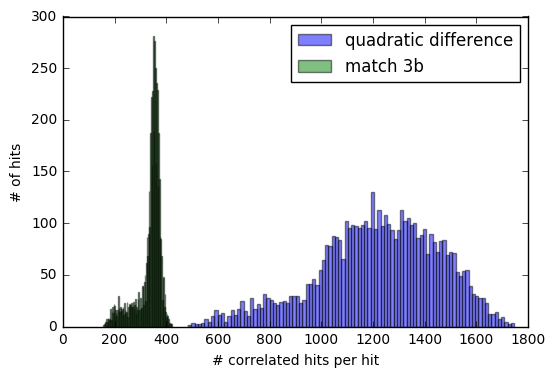

In [5]:
pyplot.hist(np.sum(matrix_qd, axis=0), bins=100, alpha=0.5, label='quadratic difference')
pyplot.hist(np.sum(matrix_3b, axis=0), bins=100, alpha=0.5, label='match 3b')
pyplot.legend(loc='upper right')
pyplot.xlabel('# correlated hits per hit')
pyplot.ylabel('# of hits')

We can clearly see that the number of correlated hits per hit is lower for all hits using the 3B criterion. The distribution is more narrow because there are more hits that have a similar 'degree'. 

However, to really see how the 3B criterion improves over quadratic difference we need to look at the cliques that are produced by the purging algorithm. Because the [PurgingSparse](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/kernels.html#km3net-kernels-purgingsparse) GPU algorithm we've implemented operates on a sparsely stored correlation matrix we need to first convert the dense matrix to a sparse matrix.

In [6]:
clique = purging.compute(*util.dense_to_sparse(matrix_qd))
print("Quadratic Difference resulted in clique of size", len(clique))
print(clique)

clique = purging.compute(*util.dense_to_sparse(matrix_3b))
print("Match 3B resulted in clique of size", len(clique))
print(clique)

Quadratic Difference resulted in clique of size 162
[3955 3986 3994 4008 4016 4023 4031 4041 4044 4046 4054 4060 4064 4065 4068
 4069 4072 4077 4079 4081 4084 4085 4088 4089 4093 4094 4095 4097 4098 4100
 4101 4102 4103 4104 4107 4110 4111 4112 4113 4114 4116 4118 4119 4121 4123
 4125 4126 4128 4129 4130 4131 4132 4133 4134 4135 4136 4139 4142 4143 4145
 4146 4147 4148 4149 4150 4151 4154 4155 4156 4157 4158 4159 4162 4163 4166
 4168 4170 4171 4172 4173 4174 4175 4177 4180 4181 4182 4185 4186 4188 4190
 4191 4192 4193 4194 4195 4196 4197 4199 4200 4203 4212 4214 4215 4216 4217
 4218 4219 4220 4221 4222 4223 4226 4227 4228 4229 4230 4231 4232 4234 4235
 4236 4237 4238 4239 4242 4244 4245 4246 4247 4252 4254 4259 4263 4264 4266
 4267 4268 4270 4271 4273 4274 4277 4280 4281 4285 4289 4292 4293 4307 4308
 4315 4316 4317 4319 4320 4325 4334 4341 4351 4378 4382 4404]
Match 3B resulted in clique of size 0
[]
